In [1]:
import logging
logger = logging.getLogger(__name__)

import sys
import json
import numpy as np
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

from tools.utils import MpcDataset, MpcDatasetHDF5
from tools.models import HVACModeMLP

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(filename)s:%(funcName)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout
)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Load data
data_path = Path().cwd().resolve() / "data" / "730days_2023-09-22_2025-09-21" / "dataset"
training_save_path = data_path / "training"
training_save_path.mkdir(exist_ok=True)

train_dataloader = DataLoader(
    MpcDatasetHDF5(
        hdf5_file=data_path / "train.h5", 
        cache_in_memory=True, 
        verbose=True), 
    batch_size=512, 
    shuffle=True
)

val_dataloader = DataLoader(MpcDatasetHDF5(hdf5_file=data_path / "val.h5", cache_in_memory=True, verbose=True), batch_size=512, shuffle=False)
test_dataloader = DataLoader(MpcDatasetHDF5(hdf5_file=data_path / "test.h5", cache_in_memory=True, verbose=True), batch_size=512, shuffle=False)


HDF5 Dataset Info for train.h5:
  Input chunks: (100, 48, 16) (chunk = 0.29 MB)
  Output chunks: (100, 3) (chunk = 0.00 MB)

  Loading entire dataset into memory from /eos/home-i01/a/ahojrup/GitLab/mpc_ahu_neural_network/data/730days_2023-09-22_2025-09-21/dataset/train.h5...
    Expected memory usage:
      Inputs:  (1782313, 48, 16) × float32 = 5.099 GB
      Outputs: (1782313, 3) × float32 = 0.020 GB
      Total:   5.119 GB

  Actual memory allocated: 5.217 GB
  Loaded 1,782,313 samples into memory
  Effective compression ratio: 0.98x



HDF5 Dataset Info for val.h5:
  Input chunks: (100, 48, 16) (chunk = 0.29 MB)
  Output chunks: (100, 3) (chunk = 0.00 MB)

  Loading entire dataset into memory from /eos/home-i01/a/ahojrup/GitLab/mpc_ahu_neural_network/data/730days_2023-09-22_2025-09-21/dataset/val.h5...
    Expected memory usage:
      Inputs:  (222789, 48, 16) × float32 = 0.637 GB
      Outputs: (222789, 3) × float32 = 0.002 GB
      Total:   0.640 GB

  Actual memory allocated: 0

In [5]:
# Load metadata and initialize model
dataset_metadata = json.loads((data_path / "stats" / "metadata.json").read_text())
model = HVACModeMLP(window_size=dataset_metadata["window"], feature_dim=dataset_metadata["feature_dim"], n_classes=dataset_metadata["num_classes"])
model.to(device=DEVICE)


# Setup training components
num_epochs = 25
lr = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    # https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
    optimizer,
    epochs=num_epochs,
    steps_per_epoch=len(train_dataloader), 
    pct_start=0.1, # % of time used for warmup
    max_lr=lr,
    anneal_strategy="cos",
    div_factor=1e1, # 10.0,
    final_div_factor=1e3, # 1000.0,
)


# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    # ============= Training Phase =============
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for batch_x, batch_y in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # Move data to device
        batch_x: torch.Tensor = batch_x.to(DEVICE)
        batch_y: torch.Tensor = batch_y.to(DEVICE)
        
        # Handle target format based on your dataset
        # If batch_y is class indices (shape: [batch_size])
        if batch_y.dim() == 1:
            target = batch_y.long()
        # If batch_y is one-hot (shape: [batch_size, num_classes])
        else:
            target = batch_y.argmax(dim=1).long()
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # ============= Validation Phase =============
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            # Move data to device
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)
            
            # Handle target format
            if batch_y.dim() == 1:
                target = batch_y.long()
            else:
                target = batch_y.argmax(dim=1).long()
            
            # Forward pass
            outputs = model(batch_x)
            loss = loss_fn(outputs, target)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, "
          f"Current LR: {scheduler.get_last_lr():.4f}, ")
    
    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, training_save_path / 'best_hvac_mode_model.pt')
        print(f"  → Saved new best model (accuracy: {val_accuracy:.2f}%)")

print(f"\nTraining complete! Best validation accuracy: {best_val_accuracy:.2f}%")

Epoch 1/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 176.58it/s]


Epoch [1/25] - Train Loss: 0.1253, Val Loss: 0.0898, Val Accuracy: 95.86%
  → Saved new best model (accuracy: 95.86%)


Epoch 2/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 165.66it/s]


Epoch [2/25] - Train Loss: 0.0753, Val Loss: 0.0752, Val Accuracy: 96.89%
  → Saved new best model (accuracy: 96.89%)


Epoch 3/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 181.33it/s]


Epoch [3/25] - Train Loss: 0.0709, Val Loss: 0.0693, Val Accuracy: 97.25%
  → Saved new best model (accuracy: 97.25%)


Epoch 4/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 196.05it/s]


Epoch [4/25] - Train Loss: 0.0672, Val Loss: 0.0689, Val Accuracy: 96.96%


Epoch 5/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 178.86it/s]


Epoch [5/25] - Train Loss: 0.0649, Val Loss: 0.0647, Val Accuracy: 97.45%
  → Saved new best model (accuracy: 97.45%)


Epoch 6/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 163.22it/s]


Epoch [6/25] - Train Loss: 0.0632, Val Loss: 0.0648, Val Accuracy: 97.36%


Epoch 7/25 - Validation: 100%|██████████| 436/436 [00:03<00:00, 125.47it/s]


Epoch [7/25] - Train Loss: 0.0615, Val Loss: 0.0575, Val Accuracy: 97.59%
  → Saved new best model (accuracy: 97.59%)


Epoch 8/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 189.01it/s]


Epoch [8/25] - Train Loss: 0.0605, Val Loss: 0.0565, Val Accuracy: 97.61%
  → Saved new best model (accuracy: 97.61%)


Epoch 9/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 180.99it/s]


Epoch [9/25] - Train Loss: 0.0594, Val Loss: 0.0568, Val Accuracy: 97.54%


Epoch 10/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 167.16it/s]


Epoch [10/25] - Train Loss: 0.0582, Val Loss: 0.0640, Val Accuracy: 97.31%


Epoch 11/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 167.08it/s]


Epoch [11/25] - Train Loss: 0.0572, Val Loss: 0.0579, Val Accuracy: 97.53%


Epoch 12/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 189.41it/s]


Epoch [12/25] - Train Loss: 0.0563, Val Loss: 0.0668, Val Accuracy: 97.07%


Epoch 13/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 175.50it/s]


Epoch [13/25] - Train Loss: 0.0553, Val Loss: 0.0558, Val Accuracy: 97.60%


Epoch 14/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 173.36it/s]


Epoch [14/25] - Train Loss: 0.0542, Val Loss: 0.0567, Val Accuracy: 97.62%
  → Saved new best model (accuracy: 97.62%)


Epoch 15/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 172.34it/s]


Epoch [15/25] - Train Loss: 0.0532, Val Loss: 0.0528, Val Accuracy: 97.72%
  → Saved new best model (accuracy: 97.72%)


Epoch 16/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 196.25it/s]


Epoch [16/25] - Train Loss: 0.0526, Val Loss: 0.0541, Val Accuracy: 97.67%


Epoch 17/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 179.68it/s]


Epoch [17/25] - Train Loss: 0.0515, Val Loss: 0.0528, Val Accuracy: 97.73%
  → Saved new best model (accuracy: 97.73%)


Epoch 18/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 170.48it/s]


Epoch [18/25] - Train Loss: 0.0507, Val Loss: 0.0515, Val Accuracy: 97.76%
  → Saved new best model (accuracy: 97.76%)


Epoch 19/25 - Validation: 100%|██████████| 436/436 [00:03<00:00, 125.73it/s]


Epoch [19/25] - Train Loss: 0.0500, Val Loss: 0.0535, Val Accuracy: 97.75%


Epoch 20/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 172.94it/s]


Epoch [20/25] - Train Loss: 0.0493, Val Loss: 0.0504, Val Accuracy: 97.81%
  → Saved new best model (accuracy: 97.81%)


Epoch 21/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 176.64it/s]


Epoch [21/25] - Train Loss: 0.0488, Val Loss: 0.0529, Val Accuracy: 97.75%


Epoch 22/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 181.15it/s]


Epoch [22/25] - Train Loss: 0.0482, Val Loss: 0.0519, Val Accuracy: 97.80%


Epoch 23/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 178.24it/s]


Epoch [23/25] - Train Loss: 0.0479, Val Loss: 0.0521, Val Accuracy: 97.79%


Epoch 24/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 174.20it/s]


Epoch [24/25] - Train Loss: 0.0476, Val Loss: 0.0518, Val Accuracy: 97.80%


Epoch 25/25 - Validation: 100%|██████████| 436/436 [00:02<00:00, 175.54it/s]

Epoch [25/25] - Train Loss: 0.0475, Val Loss: 0.0518, Val Accuracy: 97.80%

Training complete! Best validation accuracy: 97.81%


In [6]:
# ============= Test Phase =============
print("\nEvaluating on test set...")

# Load metadata and initialize model
dataset_metadata = json.loads((data_path / "stats" / "metadata.json").read_text())
model = HVACModeMLP(window_size=dataset_metadata["window"], feature_dim=dataset_metadata["feature_dim"], n_classes=dataset_metadata["num_classes"])
model.to(device=DEVICE)

# Load best model
checkpoint = torch.load(training_save_path / 'best_hvac_mode_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
test_correct = 0
test_total = 0
class_correct = [0] * dataset_metadata["num_classes"]
class_total = [0] * dataset_metadata["num_classes"]

all_targets = []
all_preds = []

with torch.no_grad():
    for batch_x, batch_y in tqdm(test_dataloader, desc="Testing"):
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        
        if batch_y.dim() == 1:
            target = batch_y.long()
        else:
            target = batch_y.argmax(dim=1).long()
        
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()
        
        # Per-class accuracy
        for i in range(target.size(0)):
            label = target[i].item()
            class_total[label] += 1
            if predicted[i] == target[i]:
                class_correct[label] += 1
        
        # For confusion matrix
        all_targets.extend(target.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Print final results
test_accuracy = 100 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print("\nPer-class accuracies:")
for i in range(dataset_metadata["num_classes"]):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"  Mode {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")


Evaluating on test set...


Testing: 100%|██████████| 436/436 [00:11<00:00, 37.73it/s]


Test Accuracy: 97.88%

Per-class accuracies:
  Mode 0: 93.37% (30794/32979)
  Mode 1: 98.73% (186244/188633)
  Mode 2: 87.43% (1029/1177)


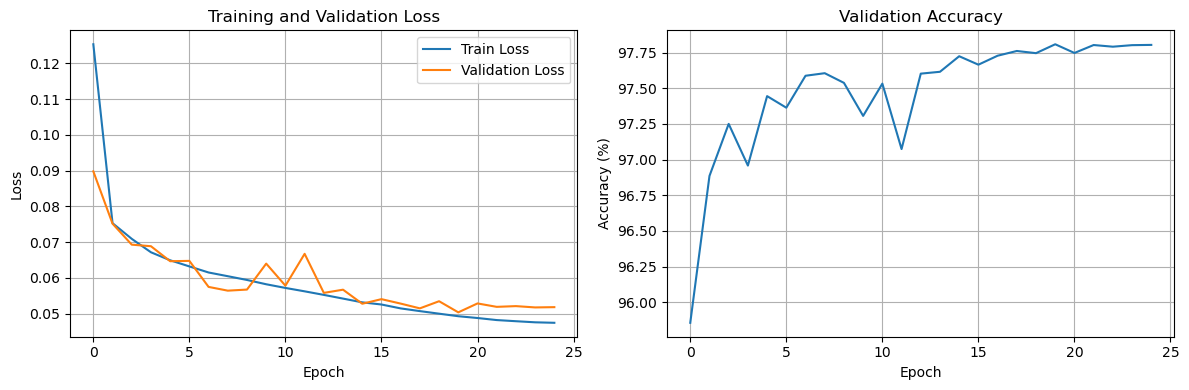

In [7]:
# Optional: Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig(training_save_path / 'training_curves.png')
plt.show()

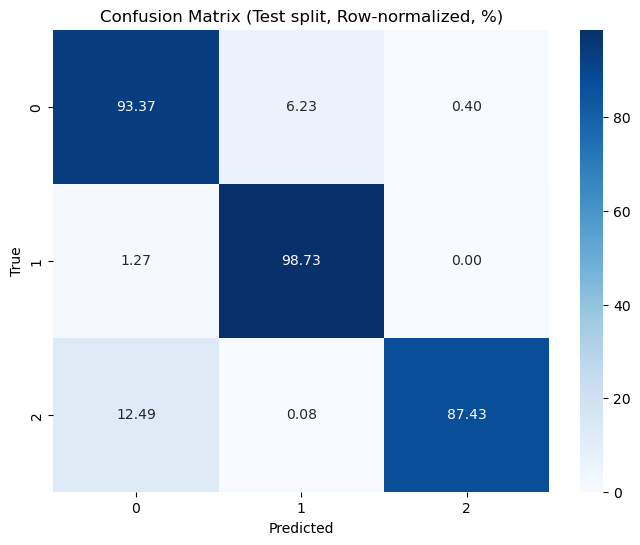

In [8]:
# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Normalize by true class (row-wise)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test split, Row-normalized, %)')
plt.savefig(training_save_path / 'test_confusion_matrix.png')
plt.show()

In [ ]:
# # Train a simple decision tree to check feature importance
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(max_depth=5)
# clf.fit(X_train_flattened, y_train)